# CITATION LOCATION - clustering analysis using street/cross street location.  "Beat" was used in the previous iteration to represent location.  I wanted to explore what a higher location granularity would produce.

Holding other variables constant and only examining for location, am I able to find areas of the city with specific types of clustering?

Holding other variables constant and only examining for citation type, am I able to find areas of the city with specific types of clustering?

visualizing results:
compare/contrast dbscan with gmm

Process:
1. identify locations with highest silhouette scores
1. for each of those locations, examine clustering using DBSCAN, GMM, and Hierarcical
1. which method seems to do the best job?

tell story with clustering results:
https://towardsdatascience.com/cluster-analysis-create-visualize-and-interpret-customer-segments-474e55d00ebb
1. scale data
1. find features with highest variance
1. for those features, show visualization
1. tell story


### IMPORT LIBRARIES

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime
import glob
pd.set_option('display.max_columns', None)
sns.set(style='darkgrid')
# plt.style.use('bmh')
plt.rcParams['patch.edgecolor'] = 'none'
import jenkspy

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

### DEFINE FUNCTIONS

In [4]:
# create function to plot the difference
# between characteristics in clusters and characteristics in the whole dataset

def plot_clusters(df, df_clusters, cluster_attribute):
    
    fig, ax = plt.subplots(figsize=(12, 6))

    df_clusters.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,[cluster_attribute]].reset_index().merge(
    df.groupby(['charge_description']).agg(['mean']).loc[:,[cluster_attribute]].reset_index(),
    how='left',
    on='charge_description',
    suffixes=('_cluster', '_all_data')).set_index(['cluster', 'charge_description']).droplevel(level=1, axis=1).plot(ax=ax, 
                                                                                                                     linewidth=6,
                                                                                                                    alpha=.7)

    # enlarge legend line colors
    leg = ax.legend(loc='center left', bbox_to_anchor=(1.0, .5))
    for line in leg.get_lines():
        line.set_linewidth(12.0)
        
    # force the x-axis to display all tickmark labels
    ax.set_xticks(range(0, len(list(df_clusters.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,[cluster_attribute]].reset_index().merge(
        df.groupby(['charge_description']).agg(['mean']).loc[:,[cluster_attribute]],
        how='left',
        on='charge_description').set_index(['cluster', 'charge_description']).index)),1))

    ax.set_xticklabels(list(df_clusters.groupby(['cluster', 'charge_description']).agg(['mean']).loc[:,[cluster_attribute]].reset_index().merge(
        df.groupby(['charge_description']).agg(['mean']).loc[:,[cluster_attribute]],
        how='left',
        on='charge_description').set_index(['cluster', 'charge_description']).index))

    plt.title('CLUSTER DIFFERENCES  -  ' + cluster_attribute.upper(), fontsize=14)
    plt.ylabel(cluster_attribute)
    plt.xticks(rotation=60, horizontalalignment="right");

### IMPORT DATA

In [5]:
# read in data that has already been preprocessed
df = pd.read_csv('data/clustering_features.csv')

In [6]:
df.shape

(38417, 9)

In [7]:
df.head()

beat  cited_person_age                charge_description          street  \
0  12.0              19.0  Speed Greater Than R&P or Posted       E Shea Bl   
1  12.0              36.0  Speed Greater Than R&P or Posted       E Shea Bl   
2   7.0              61.0  Speed Greater Than R&P or Posted  N Goldwater Bl   
3   7.0              59.0  Speed Greater Than R&P or Posted  N Goldwater Bl   
4  19.0              23.0  Speed Greater Than R&P or Posted       N Pima Rd   

   month  day_of_week  hour_of_day               place_id      age_breaks  
0      7            2            7       E Shea Bl - 6xxx  (17.999, 24.0]  
1      7            2            8       E Shea Bl - 6xxx    (29.0, 39.0]  
2      7            2            8  N Goldwater Bl - 4xxx    (51.0, 97.0]  
3      7            3            8  N Goldwater Bl - 4xxx    (51.0, 97.0]  
4      7            5           22       N Pima Rd - 2xxx  (17.999, 24.0]

In [8]:
# drop features I don't want to use for now
# df.drop(['place_id'], axis=1, inplace=True)
# df.drop(['citation_time'], axis=1, inplace=True)
df.drop(['beat'], axis=1, inplace=True)
df.drop(['age_breaks'], axis=1, inplace=True)
df.drop(['street'], axis=1, inplace=True)

In [92]:
# df.drop(['tcmainid'], axis=1, inplace=True)

In [9]:
df.head()

cited_person_age                charge_description  month  day_of_week  \
0              19.0  Speed Greater Than R&P or Posted      7            2   
1              36.0  Speed Greater Than R&P or Posted      7            2   
2              61.0  Speed Greater Than R&P or Posted      7            2   
3              59.0  Speed Greater Than R&P or Posted      7            3   
4              23.0  Speed Greater Than R&P or Posted      7            5   

   hour_of_day               place_id  
0            7       E Shea Bl - 6xxx  
1            8       E Shea Bl - 6xxx  
2            8  N Goldwater Bl - 4xxx  
3            8  N Goldwater Bl - 4xxx  
4           22       N Pima Rd - 2xxx

In [10]:
# verify no null values remain
df.isnull().sum()

cited_person_age      0
charge_description    0
month                 0
day_of_week           0
hour_of_day           0
place_id              0
dtype: int64

In [11]:
# how many street locations are there?
len(df.place_id.unique())

1883

In [12]:
# find top 30 locations by count of citation
df.place_id.value_counts().head(30)

N Scottsdale Rd - 2xxx                     948
E Indian School Rd - 6xxx                  795
N Pima Rd - 2xxx                           643
N Scottsdale Rd - 1xxx                     622
E Indian Bend Rd - 7xxx                    608
E Camelback Rd - 7xxx                      601
N Hayden Rd - 1xxx                         523
N Scottsdale Rd - 8xxx                     489
E McDowell Rd - 6xxx                       464
E Indian School Rd - 7xxx                  456
E Chaparral Rd - 7xxx                      418
E Via Linda - 1xxx                         354
E Shea Bl - 6xxx                           351
N 64th St / E Cholla St -  xxx             329
E Redfield Rd - 7xxx                       314
E Indian School Rd - 8xxx                  313
E Shea Bl - 8xxx                           298
E McDowell Rd - 7xxx                       297
N Scottsdale Rd / E Thomas Rd -  xxx       293
E Shea Bl - 7xxx                           285
E Frank Lloyd Wright Bl / L101 -  xxx      279
E Thomas Rd -

In [13]:
# find top locations by count of citation
df.place_id.value_counts().head(30).index

Index(['N Scottsdale Rd - 2xxx', 'E Indian School Rd - 6xxx',
       'N Pima Rd - 2xxx', 'N Scottsdale Rd - 1xxx', 'E Indian Bend Rd - 7xxx',
       'E Camelback Rd - 7xxx', 'N Hayden Rd - 1xxx', 'N Scottsdale Rd - 8xxx',
       'E McDowell Rd - 6xxx', 'E Indian School Rd - 7xxx',
       'E Chaparral Rd - 7xxx', 'E Via Linda - 1xxx', 'E Shea Bl - 6xxx',
       'N 64th St / E Cholla St -  xxx', 'E Redfield Rd - 7xxx',
       'E Indian School Rd - 8xxx', 'E Shea Bl - 8xxx', 'E McDowell Rd - 7xxx',
       'N Scottsdale Rd / E Thomas Rd -  xxx', 'E Shea Bl - 7xxx',
       'E Frank Lloyd Wright Bl / L101 -  xxx', 'E Thomas Rd - 6xxx',
       'E Camelback Rd - 6xxx', 'E Thomas Rd - 8xxx',
       'E McDowell Rd / N Scottsdale Rd -  xxx',
       'N Hayden Rd / E Indian School Rd -  xxx',
       'E Camelback Rd / N Scottsdale Rd -  xxx',
       'N Scottsdale Rd / E Shea Bl -  xxx', 'N Thompson Peak Py - 1xxx',
       'E Thomas Rd - 7xxx'],
      dtype='object')

In [14]:
# limit dataset to top 30
df = df[df.place_id.isin(list(df.place_id.value_counts().head(30).index))]

In [15]:
# how many values are captured in the limited dataset?
df.shape

(11850, 6)

In [16]:
X = pd.get_dummies(df.drop(['place_id'], axis=1))

In [17]:
X.head()

cited_person_age  month  day_of_week  hour_of_day  \
0               19.0      7            2            7   
1               36.0      7            2            8   
4               23.0      7            5           22   
6               66.0      7            5           19   
13              47.0      7            5           12   

    charge_description_DUI-Impaired to Slightest Degree  \
0                                                   0     
1                                                   0     
4                                                   0     
6                                                   0     
13                                                  0     

    charge_description_Drug Paraphernalia-Possess/Use  \
0                                                   0   
1                                                   0   
4                                                   0   
6                                                   0   
13                                                  0   

    charge_description_Exceed 15mph In School Crossing  \
0                                                   0    
1                                                   0    
4                                                   0    
6                                                   0    
13                                                  0    

    charge_description_Exceed Limit By More Than 20mph  \
0                                                   0    
1                                                   0    
4                                                   0    
6                                                   0    
13                                                  0    

    charge_description_Expired/No Arizona Registration  \
0                                                   0    
1                                                   0    
4                                                   0    
6                                                   0    
13                                                  0    

    charge_description_Fail to Obey Traffic Control Device  \
0                                                   0        
1                                                   0        
4                                                   0        
6                                                   0        
13                                                  0        

    charge_description_Fail to Stop For Red Signal  \
0                                                0   
1                                                0   
4                                                0   
6                                                0   
13                                               0   

    charge_description_Fail to Stop at Stop Sign  \
0                                              0   
1                                              0   
4                                              0   
6                                              0   
13                                             0   

    charge_description_Failure to Control Speed to Avoid A Collision  \
0                                                   0                  
1                                                   0                  
4                                                   0                  
6                                                   0                  
13                                                  0                  

    charge_description_No Proof of Insurance  \
0                                          0   
1                                          0   
4                                          0   
6                                          0   
13                                         0   

    charge_description_Speed Greater Than R&P or Posted  \
0                                                   1     
1                                                   1     
4     

In [18]:
X.shape

(11850, 16)

In [19]:
# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [20]:
# which beats seem to be the most clustered?
sil_score = []
cluster_count = []

for location in list(df.place_id.unique()):
    
    df2 = df[df.place_id == location]
    X = pd.get_dummies(df2.drop(['place_id'], axis=1))
    
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)
    
    # Defining the agglomerative clustering
    dbscan_cluster = DBSCAN(eps=.5, min_samples=5)

    # Fit model
    clusters = dbscan_cluster.fit_predict(X_std)
    
    # capture cluster count
    cluster_count.append(len(set(clusters)) - (1 if -1 in clusters else 0))

    # capture model fit
    if pd.Series(clusters).nunique() > 1:
        sil_score.append(round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3))
    else:
        sil_score.append(np.nan)

### Which locations seem the most clustered?

In [21]:
cluster_scores = pd.DataFrame(list(zip(list(df.place_id.unique()), sil_score, cluster_count)),
             columns=['beat', 'sil_score', 'cluster_count']) \
        .set_index('beat') \
        .sort_values(by=['sil_score', 'cluster_count'], ascending=False)

cluster_scores

sil_score  cluster_count
beat                                                             
E McDowell Rd - 7xxx                        -0.057              1
E Frank Lloyd Wright Bl / L101 -  xxx       -0.073              1
N 64th St / E Cholla St -  xxx              -0.095             16
E Shea Bl - 8xxx                            -0.102              1
N Hayden Rd / E Indian School Rd -  xxx     -0.109              1
E Thomas Rd - 6xxx                          -0.158              4
E Thomas Rd - 8xxx                          -0.169              6
E Camelback Rd - 7xxx                       -0.173             11
N Thompson Peak Py - 1xxx                   -0.175              7
N Hayden Rd - 1xxx                          -0.184             10
E Camelback Rd - 6xxx                       -0.187              3
N Scottsdale Rd - 1xxx                      -0.192              2
E Indian School Rd - 7xxx                   -0.198              4
E Redfield Rd - 7xxx                        -0.202              4
E Indian School Rd - 8xxx                   -0.221              6
E Shea Bl - 6xxx                            -0.222              9
N Scottsdale Rd - 2xxx                      -0.235             21
E McDowell Rd - 6xxx                        -0.240              9
E Chaparral Rd - 7xxx                       -0.250              8
E Indian School Rd - 6xxx                   -0.270             20
N Scottsdale Rd - 8xxx                      -0.271             10
N Pima Rd - 2xxx                            -0.286             11
E Via Linda - 1xxx                          -0.316              7
E Indian Bend Rd - 7xxx                     -0.351             15
E McDowell Rd / N Scottsdale Rd -  xxx         NaN              0
N Scottsdale Rd / E Shea Bl -  xxx             NaN              0
E Shea Bl - 7xxx                               NaN              0
N Scottsdale Rd / E Thomas Rd -  xxx           NaN              0
E Camelback Rd / N Scottsdale Rd -  xxx        NaN              0
E Thomas Rd - 7xxx                             NaN              0

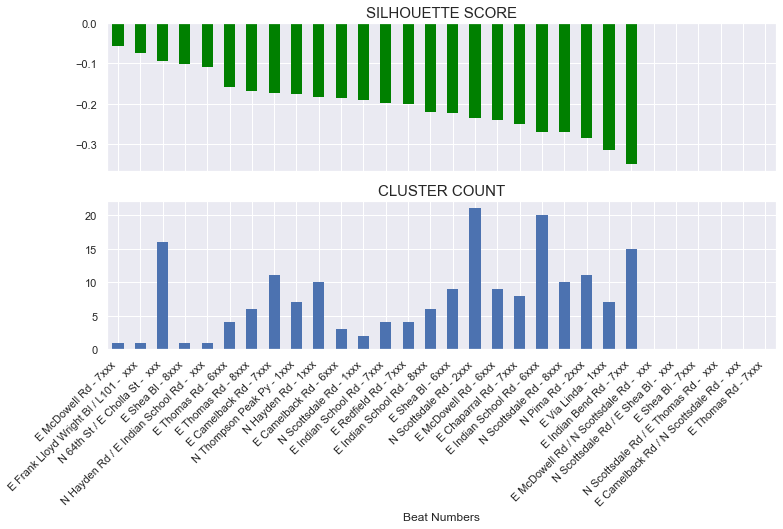

In [22]:
# plot silhouette score and cluster count
fig, (ax0, ax1) = plt.subplots(nrows=2,ncols=1, sharex=True, figsize=(12, 6))

cluster_scores.loc[:,['sil_score']] \
    .plot(kind='bar', color='green', legend=False, ax=ax0)
ax0.set_title('SILHOUETTE SCORE', fontsize=15)


cluster_scores.loc[:,['cluster_count']] \
    .plot(kind='bar', legend=False, ax=ax1);
ax1.set_title('CLUSTER COUNT', fontsize=15)

plt.xlabel('Beat Numbers')
plt.xticks(rotation=45, horizontalalignment="right");

# Based on results above, examine clustering at specific locations.

1. N 64th St / E Cholla St -  xxx
1. E Thomas Rd - 6xxx
1. E Thomas Rd - 8xxx
1. E Camelback Rd - 7xxx
1. N Thompson Peak Py - 1xxx

### N 64th St / E Cholla St -  xxx

In [95]:
df_sub = df[df.place_id == 'N 64th St / E Cholla St -  xxx']

In [96]:
X = pd.get_dummies(df_sub)

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [25]:
# find best DBSCAN parameters
cluster_count = []
sil_score = []
eps_ = []
min_samples_ = []

for eps in [.1, .5, 1, 5, 10]:
    for min_samples in [5, 10, 25, 50]:
    
        # Defining the agglomerative clustering
        dbscan_cluster = DBSCAN(eps=eps, min_samples=min_samples)

        # Fit model
        clusters = dbscan_cluster.fit_predict(X_std)
        
        # capture cluster count
        cluster_count.append(len(set(clusters)) - (1 if -1 in clusters else 0))
        
        # capture model fit
        if pd.Series(clusters).nunique() > 1:
            sil_score.append(round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3))
        else:
            sil_score.append(np.nan)
        
        # record parameter values
        eps_.append(eps)
        min_samples_.append(min_samples)

In [26]:
# tabulate param results from above
# sort by silhouette score & cluster count
pd.DataFrame(list(list(zip(sil_score, cluster_count, eps_, min_samples_))), 
            columns=['sil_score', 'cluster_count', 'eps', 'min_samples']) \
        .sort_values(by=['sil_score', 'cluster_count'], ascending=False)

sil_score  cluster_count   eps  min_samples
16      0.764              1  10.0            5
17      0.764              1  10.0           10
18      0.764              1  10.0           25
19      0.764              1  10.0           50
14      0.633              1   5.0           25
15      0.633              1   5.0           50
12      0.564              2   5.0            5
13      0.564              2   5.0           10
8       0.200              5   1.0            5
10      0.158              1   1.0           25
9       0.124              4   1.0           10
4      -0.095             16   0.5            5
5      -0.273              2   0.5           10
0         NaN              0   0.1            5
1         NaN              0   0.1           10
2         NaN              0   0.1           25
3         NaN              0   0.1           50
6         NaN              0   0.5           25
7         NaN              0   0.5           50
11        NaN              0   1.0           50

## Model best parameters from above

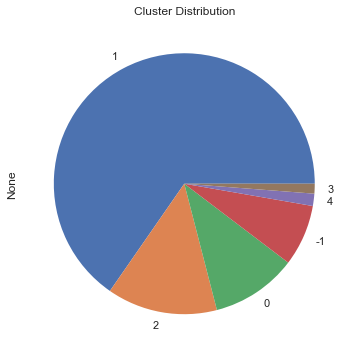

In [27]:
plt.figure(figsize=(6, 6))

dbscan_cluster = DBSCAN(eps=1, min_samples=5)
clusters = dbscan_cluster.fit_predict(X_std)
pd.Series(clusters).value_counts().plot(kind='pie', title='Cluster Distribution');

In [36]:
df_sub.shape

(329, 6)

In [37]:
clusters.shape

(329,)

In [38]:
# format data for plotting
df_clusters = pd.concat([df_sub.reset_index(drop=True), pd.Series(clusters).rename('cluster')], axis=1)

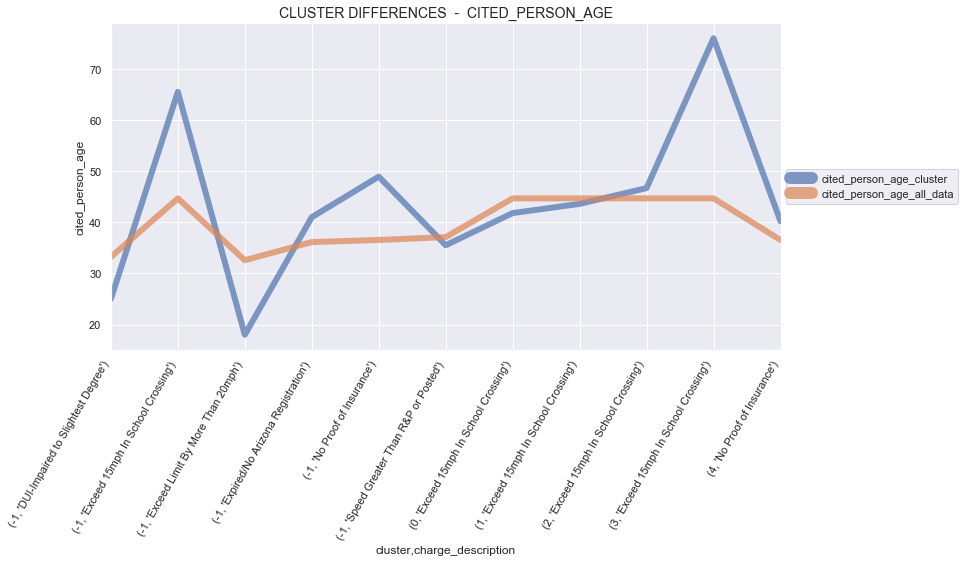

In [41]:
plot_clusters(df, df_clusters, 'cited_person_age')

In [30]:
df_clusters

cited_person_age                             charge_description  month  \
0                  19.0               Speed Greater Than R&P or Posted      7   
1                  36.0               Speed Greater Than R&P or Posted      7   
2                  23.0               Speed Greater Than R&P or Posted      7   
3                  66.0               Speed Greater Than R&P or Posted      7   
4                  47.0               Speed Greater Than R&P or Posted      7   
...                 ...                                            ...    ...   
11845              31.0                Exceed Limit By More Than 20mph     10   
11846              62.0                          No Proof of Insurance     10   
11847              39.0               Speed Greater Than R&P or Posted      9   
11848              20.0               Speed Greater Than R&P or Posted      9   
11849              22.0  Failure to Control Speed to Avoid A Collision     10   

       day_of_week  hour_of_day                               place_id  \
0                2            7                       E Shea Bl - 6xxx   
1                2            8                       E Shea Bl - 6xxx   
2                5           22                       N Pima Rd - 2xxx   
3                5           19                       N Pima Rd - 2xxx   
4                5           12                       N Pima Rd - 2xxx   
...            ...          ...                                    ...   
11845            2           16                  E Chaparral Rd - 7xxx   
11846            2           22                       E Shea Bl - 7xxx   
11847            3           13                E Indian Bend Rd - 7xxx   
11848            6           12  E Frank Lloyd Wright Bl / L101 -  xxx   
11849            1           16                     E Thomas Rd - 7xxx   

       cluster  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0  
...        ...  
11845      NaN  
11846      NaN  
11847      NaN  
11848      NaN  
11849      NaN  

[11850 rows x 7 columns]

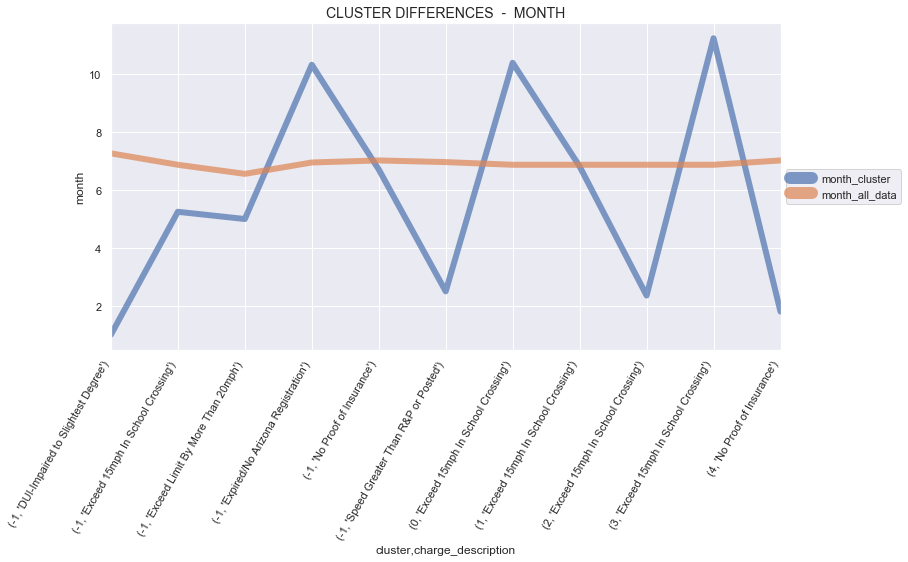

In [42]:
plot_clusters(df, df_clusters, 'month')

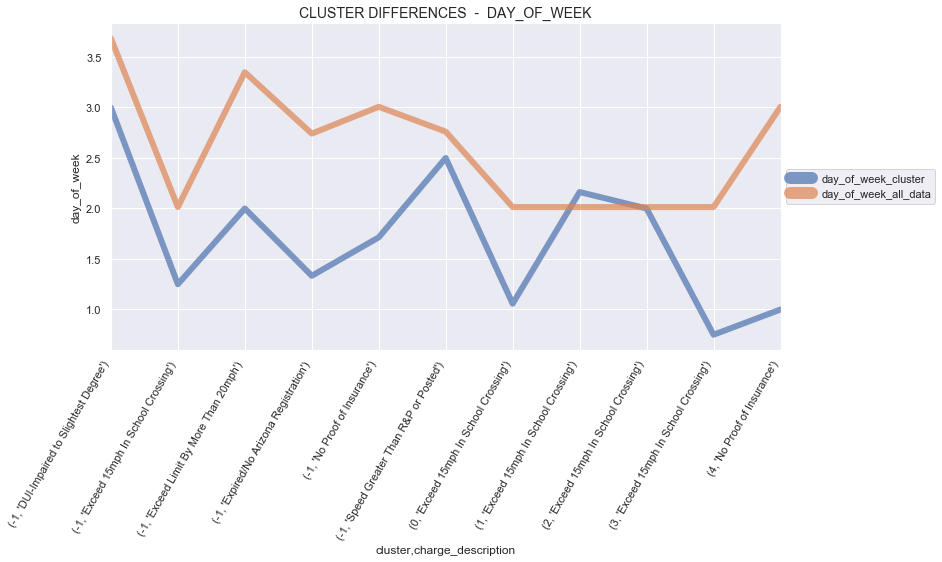

In [43]:
plot_clusters(df, df_clusters, 'day_of_week')

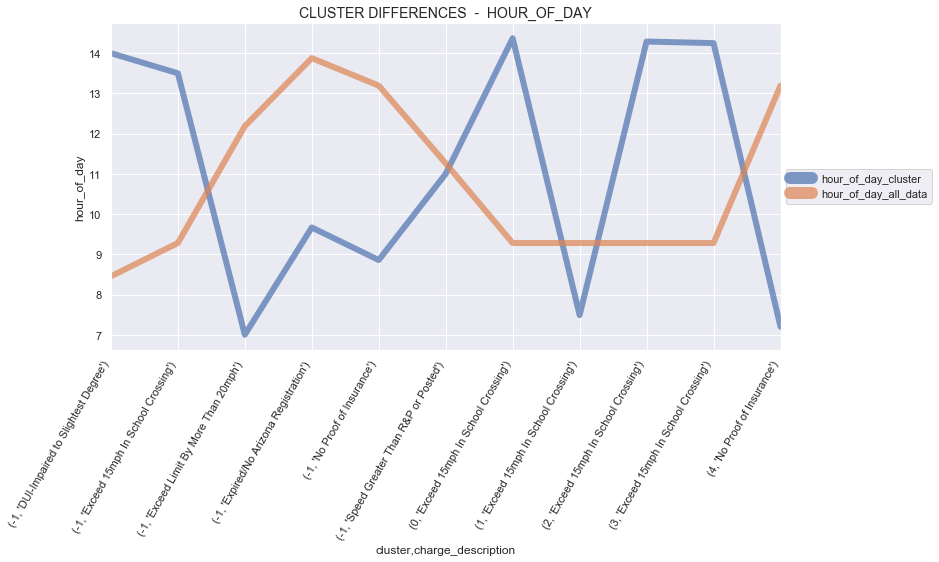

In [44]:
plot_clusters(df, df_clusters, 'hour_of_day')

### GMM

In [97]:
# find best GMM parameters
sil_score = []
num_components = []
cov_type = []

for n_components in [2, 6, 10, 14]:
    for covariance_type in ['full', 'tied', 'diag', 'spherical']:
    
        # Defining the agglomerative clustering
        gmm_cluster = GaussianMixture(n_components=n_components, covariance_type=covariance_type)

        # Fit model
        clusters = gmm_cluster.fit_predict(X_std)
        
        sil_score.append(round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3))
        
        # record parameter values
        num_components.append(n_components)
        cov_type.append(covariance_type)

In [98]:
# tabulate param results from above
# sort by silhouette score & cluster count
cluster_scores = pd.DataFrame(list(list(zip(sil_score, num_components, cov_type))), 
            columns=['sil_score', 'num_components', 'covariance_type']) \
        .sort_values(by=['sil_score'], ascending=False)

cluster_scores

sil_score  num_components covariance_type
3       0.816               2       spherical
0       0.790               2            full
2       0.713               2            diag
6       0.337               6            diag
15      0.320              14       spherical
7       0.319               6       spherical
9       0.312              10            tied
4       0.300               6            full
12      0.299              14            full
13      0.289              14            tied
11      0.275              10       spherical
10      0.265              10            diag
14      0.252              14            diag
5       0.249               6            tied
1       0.245               2            tied
8       0.140              10            full

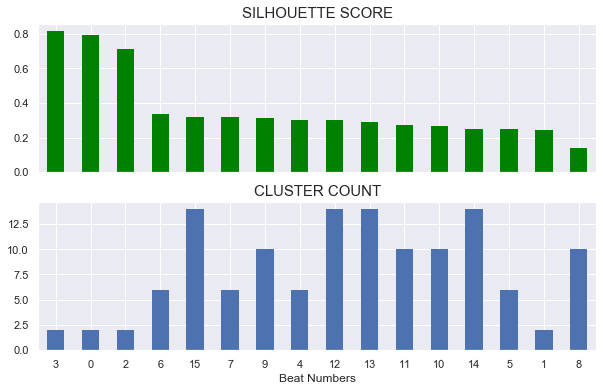

In [99]:
# plot silhouette score and cluster count
fig, (ax0, ax1) = plt.subplots(nrows=2,ncols=1, sharex=True, figsize=(10, 6))

cluster_scores.loc[:,['sil_score']] \
    .plot(kind='bar', color='green', legend=False, ax=ax0)
ax0.set_title('SILHOUETTE SCORE', fontsize=15)

cluster_scores.loc[:,['num_components']] \
    .plot(kind='bar', legend=False, ax=ax1);
ax1.set_title('CLUSTER COUNT', fontsize=15)

plt.xlabel('Beat Numbers')
plt.xticks(rotation=1);

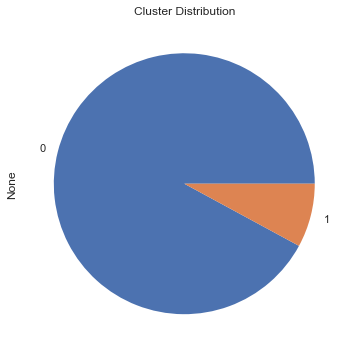

In [100]:
plt.figure(figsize=(6, 6))

gmm_cluster = GaussianMixture(n_components=2, covariance_type='spherical')
clusters = gmm_cluster.fit_predict(X_std)
pd.Series(clusters).value_counts().plot(kind='pie', title='Cluster Distribution');

Compared to DBSCAN, the size distribution of GMM is much more distributed.

In [101]:
pd.Series(clusters).value_counts(dropna=False)

0    303
1     26
dtype: int64

In [102]:
# join cluster assignment to df
df_clusters = pd.concat([df.reset_index(drop=True), pd.Series(clusters).rename('cluster')], axis=1)

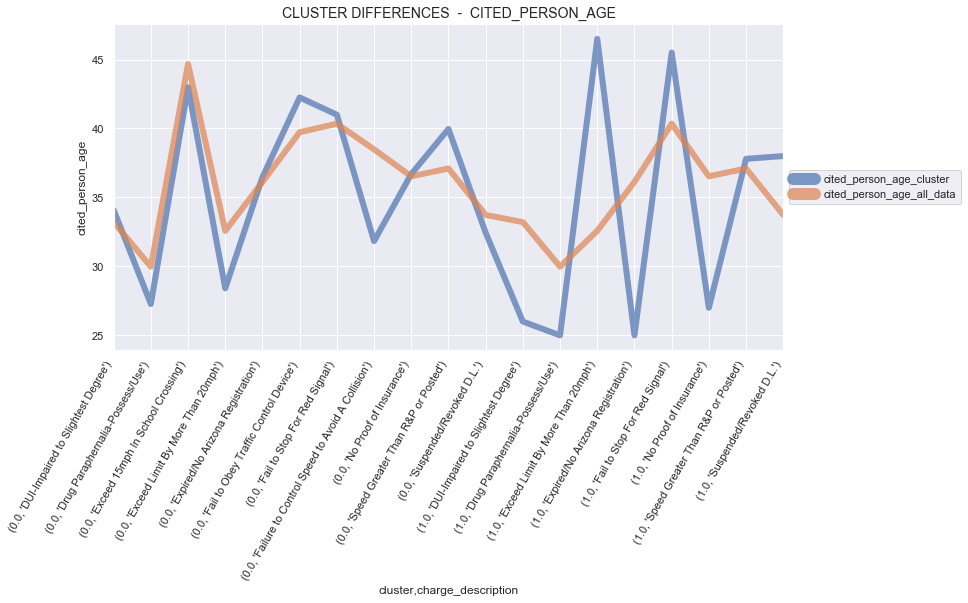

In [103]:
plot_clusters(df, df_clusters, 'cited_person_age')

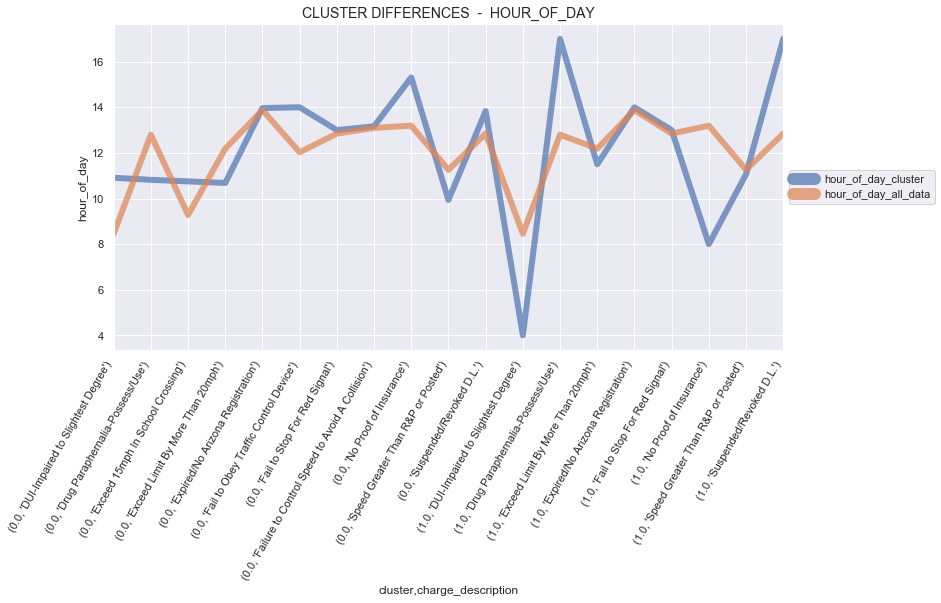

In [106]:
plot_clusters(df, df_clusters, 'hour_of_day')

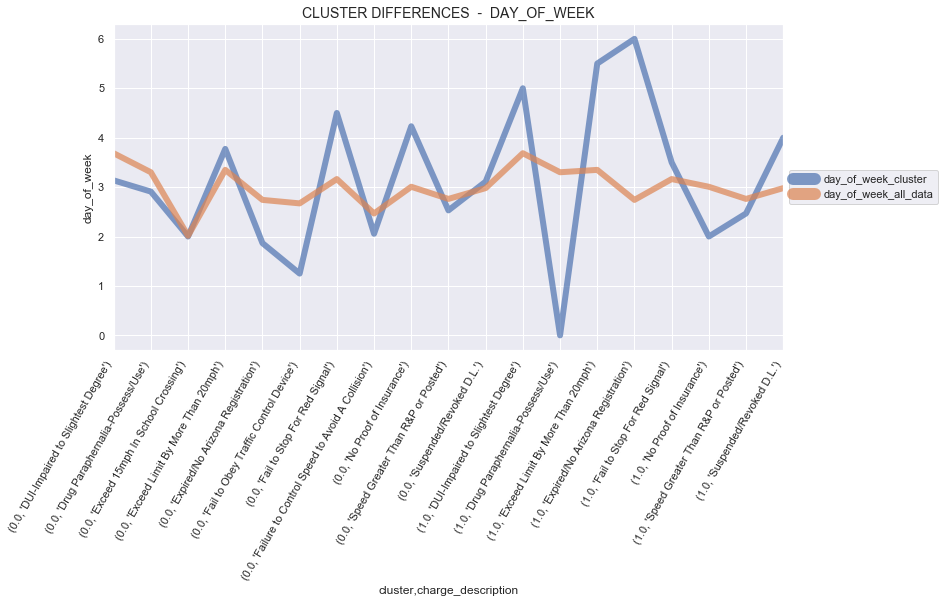

In [107]:
plot_clusters(df, df_clusters, 'day_of_week')

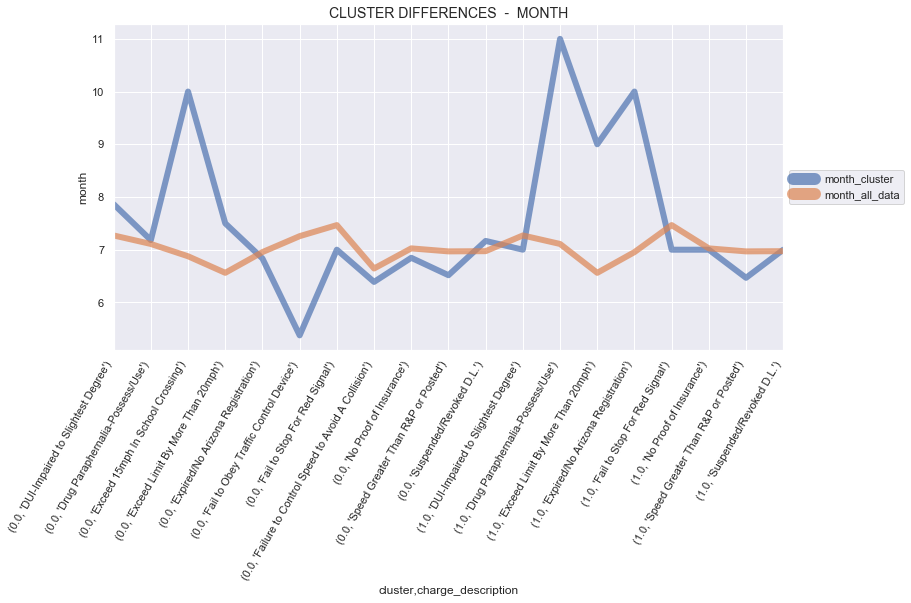

In [108]:
plot_clusters(df, df_clusters, 'month')

### Hierarcical linkage methods: 

1. **Ward**: The Ward method tends to look for spherical clusters such that the clusters are cohesive inside and differentiated from other groups. In general, this method tends to find clusters of similar size. Note that the Ward method only works with Euclidean distance.
1. **Complete**: The Complete method links clusters using their furthest observations, that is, their most dissimilar data points. Consequently, clusters created using this method tend to be comprised of highly similar observations, making the resulting groups quite compact.
1. **Average**: The Average method links clusters using their centroids. Since this method focuses on centroids and ignoring the boundary points, it tends to create larger groups than the complete method. Moreover, the clusters can be different sizes and shapes in contrast to the Ward method.

### Hierarcical

In [112]:
# find best GMM parameters
sil_score = []
num_components = []

for n_components in range(2, 20, 1):   
    agg_cluster = AgglomerativeClustering(linkage='average', 
                                          affinity='cosine',
                                          n_clusters=n_components)

    clusters = agg_cluster.fit_predict(X_std)

    sil_score.append(round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3))

    # record parameter values
    num_components.append(n_components)

In [113]:
# tabulate param results from above
# sort by silhouette score & cluster count
cluster_scores = pd.DataFrame(list(list(zip(sil_score, num_components))), 
            columns=['sil_score', 'num_components']) \
        .sort_values(by=['sil_score'], ascending=False)

cluster_scores

sil_score  num_components
12      0.336              14
13      0.330              15
14      0.322              16
17      0.321              19
16      0.321              18
15      0.321              17
11      0.316              13
10      0.312              12
9       0.300              11
0       0.290               2
1       0.286               3
7       0.282               9
6       0.263               8
8       0.259              10
5       0.249               7
4       0.243               6
3       0.237               5
2       0.231               4

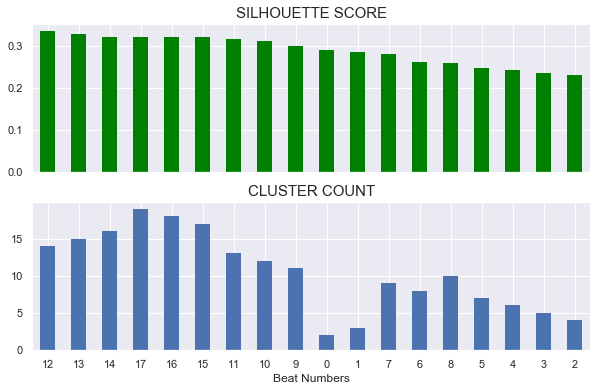

In [114]:
# plot silhouette score and cluster count
fig, (ax0, ax1) = plt.subplots(nrows=2,ncols=1, sharex=True, figsize=(10, 6))

cluster_scores.loc[:,['sil_score']] \
    .plot(kind='bar', color='green', legend=False, ax=ax0)
ax0.set_title('SILHOUETTE SCORE', fontsize=15)

cluster_scores.loc[:,['num_components']] \
    .plot(kind='bar', legend=False, ax=ax1);
ax1.set_title('CLUSTER COUNT', fontsize=15)

plt.xlabel('Beat Numbers')
plt.xticks(rotation=1);

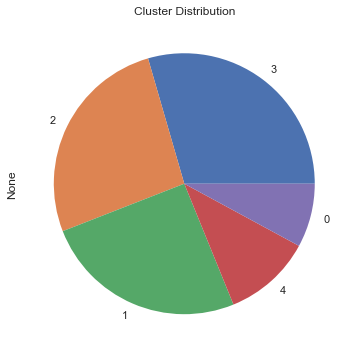

In [117]:
plt.figure(figsize=(6, 6))
agg_cluster = AgglomerativeClustering(linkage='average', 
                                      affinity='cosine',
                                      n_clusters=5)

clusters = agg_cluster.fit_predict(X_std)
pd.Series(clusters).value_counts().plot(kind='pie', title='Cluster Distribution');

Compared to DBSCAN, the size distribution of GMM is much more distributed.

In [118]:
pd.Series(clusters).value_counts(dropna=False)

3    97
2    87
1    83
4    36
0    26
dtype: int64

In [119]:
# join cluster assignment to df
df_clusters = pd.concat([df.reset_index(drop=True), pd.Series(clusters).rename('cluster')], axis=1)

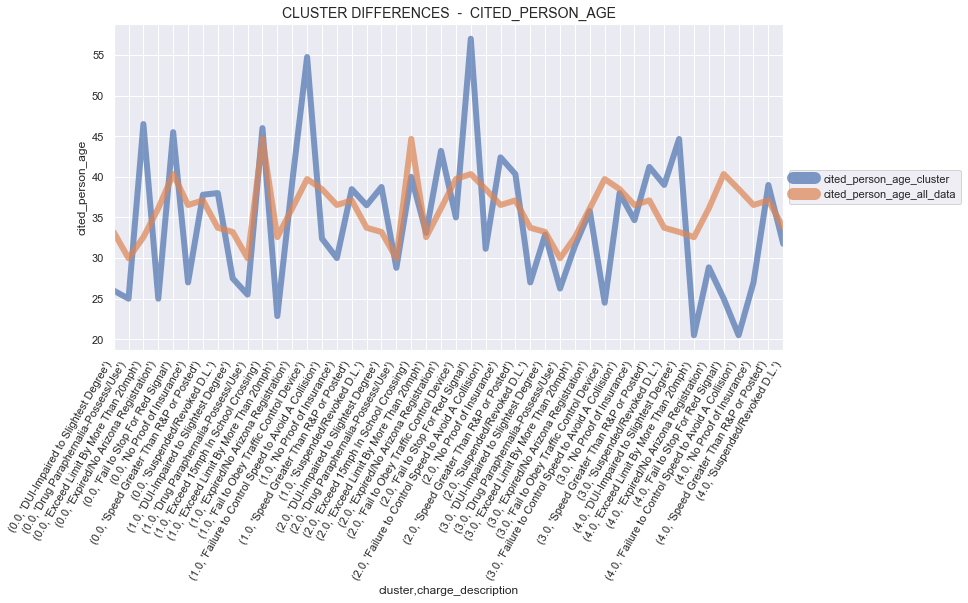

In [120]:
plot_clusters(df, df_clusters, 'cited_person_age')

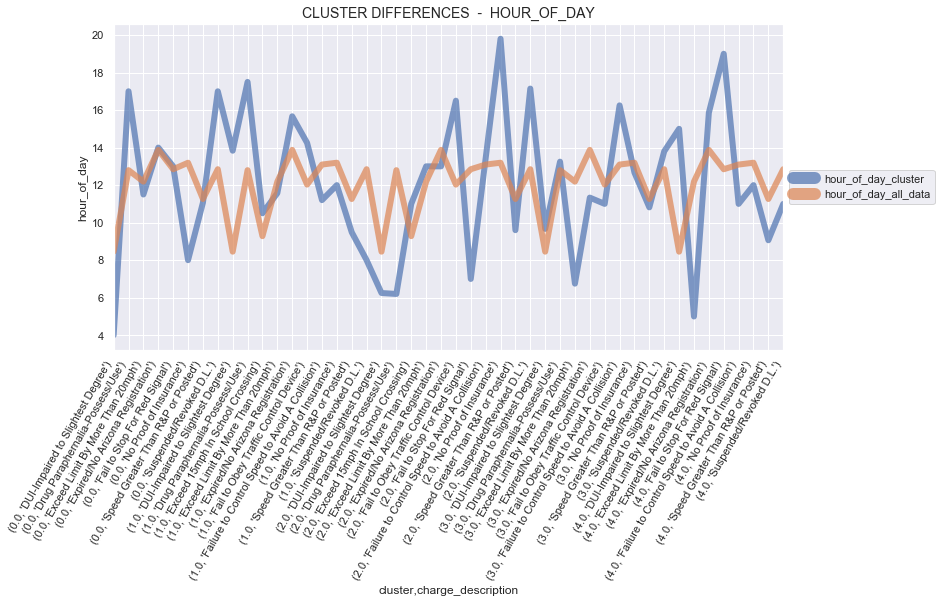

In [121]:
plot_clusters(df, df_clusters, 'hour_of_day')

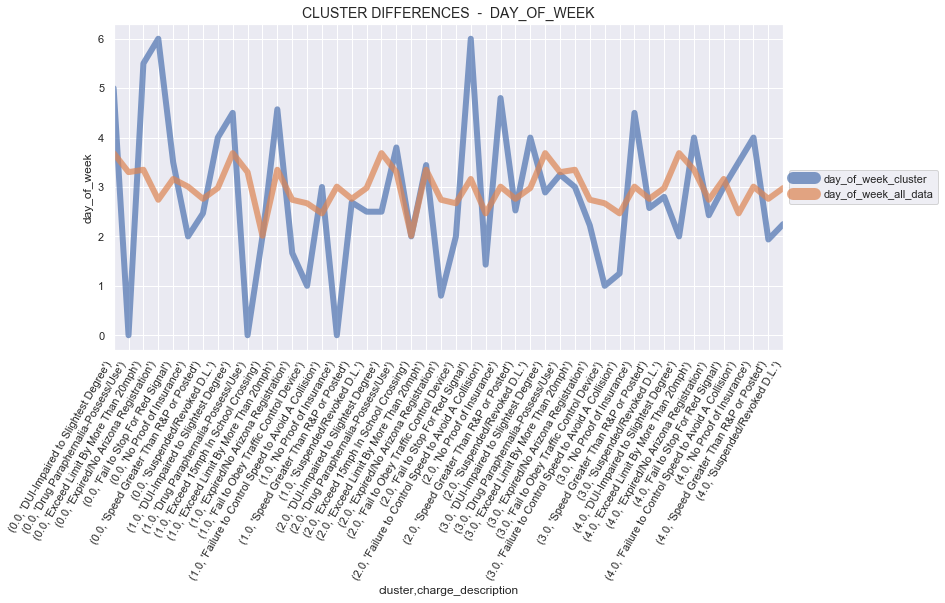

In [122]:
plot_clusters(df, df_clusters, 'day_of_week')

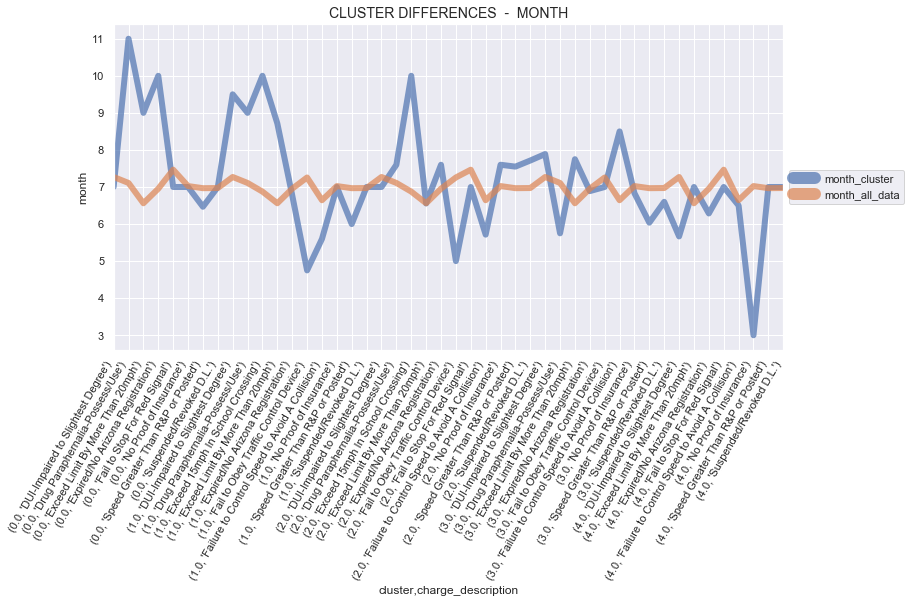

In [123]:
plot_clusters(df, df_clusters, 'month')

### E Thomas Rd - 6xxx

In [57]:
df_sub = df[df.place_id == 'E Thomas Rd - 6xxx']

In [58]:
X = pd.get_dummies(df_sub)

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [59]:
# find best DBSCAN parameters
cluster_count = []
sil_score = []
eps_ = []
min_samples_ = []

for eps in [.1, .5, 1, 5, 10]:
    for min_samples in [5, 10, 25, 50]:
    
        # Defining the agglomerative clustering
        dbscan_cluster = DBSCAN(eps=eps, min_samples=min_samples)

        # Fit model
        clusters = dbscan_cluster.fit_predict(X_std)
        
        # capture cluster count
        cluster_count.append(len(set(clusters)) - (1 if -1 in clusters else 0))
        
        # capture model fit
        if pd.Series(clusters).nunique() > 1:
            sil_score.append(round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3))
        else:
            sil_score.append(np.nan)
        
        # record parameter values
        eps_.append(eps)
        min_samples_.append(min_samples)

In [60]:
# tabulate param results from above
# sort by silhouette score & cluster count
pd.DataFrame(list(list(zip(sil_score, cluster_count, eps_, min_samples_))), 
            columns=['sil_score', 'cluster_count', 'eps', 'min_samples']) \
        .sort_values(by=['sil_score', 'cluster_count'], ascending=False)

sil_score  cluster_count   eps  min_samples
12      0.418              4   5.0            5
13      0.378              1   5.0           10
14      0.378              1   5.0           25
15      0.378              1   5.0           50
9       0.084              1   1.0           10
8       0.017              2   1.0            5
10     -0.030              1   1.0           25
4      -0.158              4   0.5            5
5      -0.179              3   0.5           10
16        NaN              1  10.0            5
17        NaN              1  10.0           10
18        NaN              1  10.0           25
19        NaN              1  10.0           50
0         NaN              0   0.1            5
1         NaN              0   0.1           10
2         NaN              0   0.1           25
3         NaN              0   0.1           50
6         NaN              0   0.5           25
7         NaN              0   0.5           50
11        NaN              0   1.0           50

## Model best parameters from above

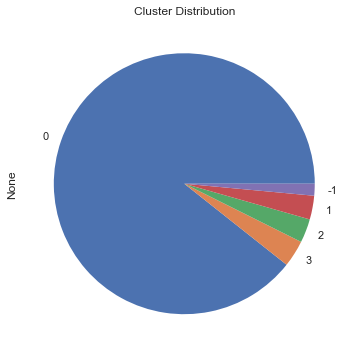

In [61]:
plt.figure(figsize=(6, 6))

dbscan_cluster = DBSCAN(eps=5, min_samples=5)
clusters = dbscan_cluster.fit_predict(X_std)
pd.Series(clusters).value_counts().plot(kind='pie', title='Cluster Distribution');

In [62]:
df_sub.shape

(272, 6)

In [63]:
clusters.shape

(272,)

In [64]:
# format data for plotting
df_clusters = pd.concat([df_sub.reset_index(drop=True), pd.Series(clusters).rename('cluster')], axis=1)

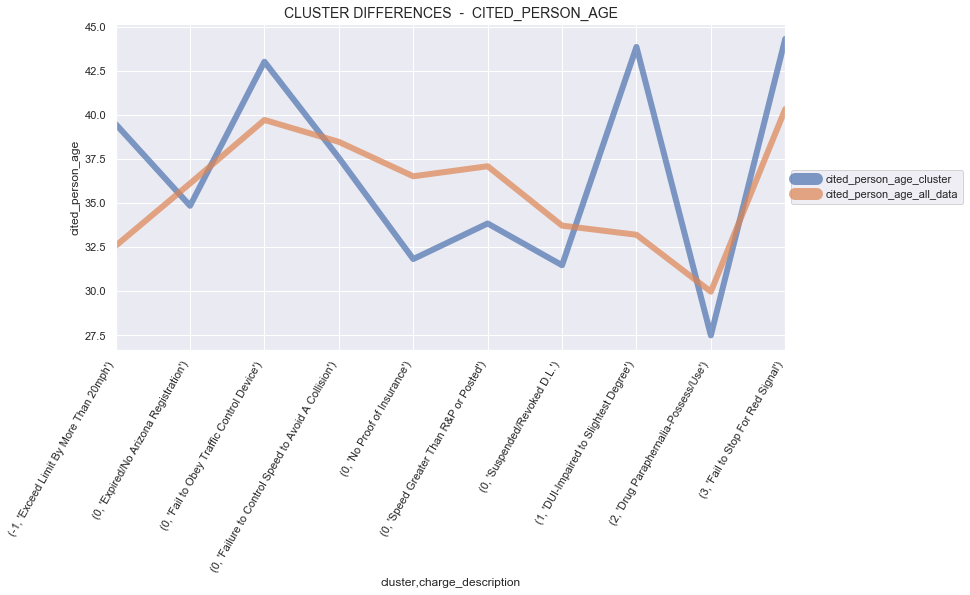

In [65]:
plot_clusters(df, df_clusters, 'cited_person_age')

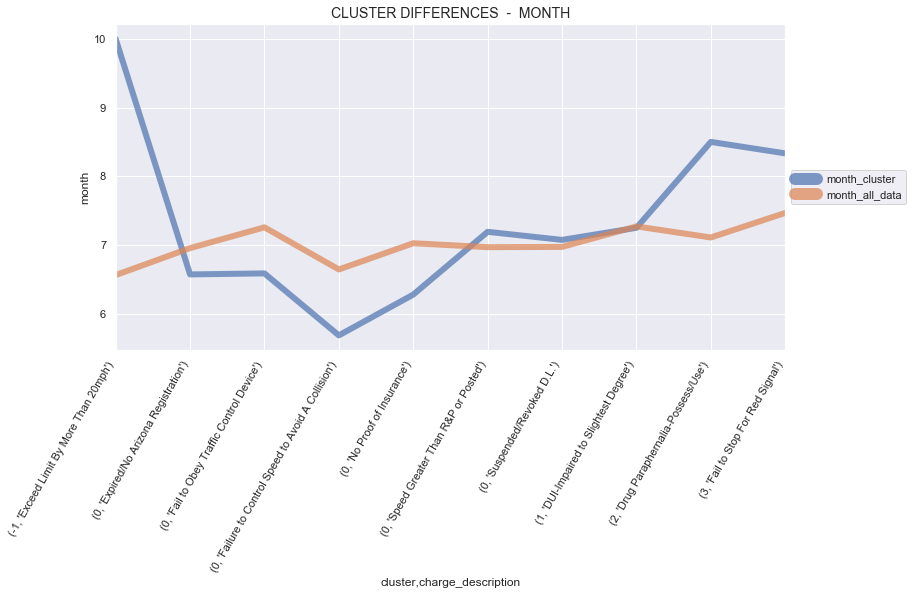

In [66]:
plot_clusters(df, df_clusters, 'month')

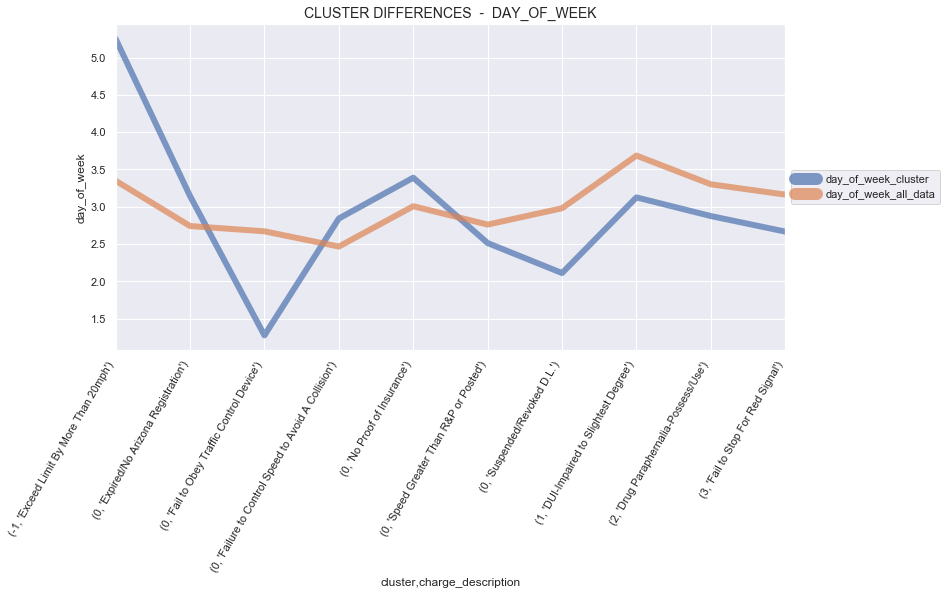

In [67]:
plot_clusters(df, df_clusters, 'day_of_week')

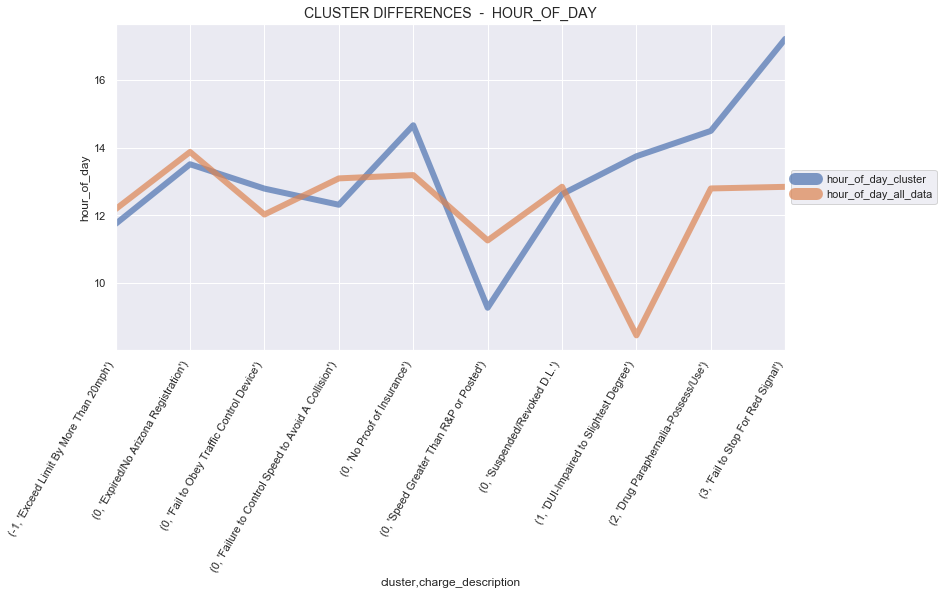

In [68]:
plot_clusters(df, df_clusters, 'hour_of_day')

### E Camelback Rd - 7xxx

In [69]:
df_sub = df[df.place_id == 'E Camelback Rd - 7xxx']

In [70]:
X = pd.get_dummies(df_sub)

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [71]:
# find best DBSCAN parameters
cluster_count = []
sil_score = []
eps_ = []
min_samples_ = []

for eps in [.1, .5, 1, 5, 10]:
    for min_samples in [5, 10, 25, 50]:
    
        # Defining the agglomerative clustering
        dbscan_cluster = DBSCAN(eps=eps, min_samples=min_samples)

        # Fit model
        clusters = dbscan_cluster.fit_predict(X_std)
        
        # capture cluster count
        cluster_count.append(len(set(clusters)) - (1 if -1 in clusters else 0))
        
        # capture model fit
        if pd.Series(clusters).nunique() > 1:
            sil_score.append(round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3))
        else:
            sil_score.append(np.nan)
        
        # record parameter values
        eps_.append(eps)
        min_samples_.append(min_samples)

In [72]:
# tabulate param results from above
# sort by silhouette score & cluster count
pd.DataFrame(list(list(zip(sil_score, cluster_count, eps_, min_samples_))), 
            columns=['sil_score', 'cluster_count', 'eps', 'min_samples']) \
        .sort_values(by=['sil_score', 'cluster_count'], ascending=False)

sil_score  cluster_count   eps  min_samples
16      0.569              2  10.0            5
17      0.569              1  10.0           10
18      0.569              1  10.0           25
19      0.569              1  10.0           50
14      0.423              1   5.0           25
15      0.423              1   5.0           50
12      0.415              5   5.0            5
13      0.415              4   5.0           10
8       0.119             14   1.0            5
10      0.072              1   1.0           25
9       0.071              4   1.0           10
11     -0.000              1   1.0           50
4      -0.173             11   0.5            5
5      -0.180              5   0.5           10
0         NaN              0   0.1            5
1         NaN              0   0.1           10
2         NaN              0   0.1           25
3         NaN              0   0.1           50
6         NaN              0   0.5           25
7         NaN              0   0.5           50

## Model best parameters from above

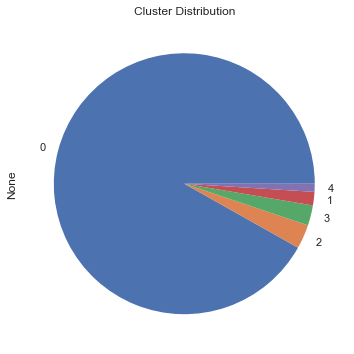

In [73]:
plt.figure(figsize=(6, 6))

dbscan_cluster = DBSCAN(eps=5, min_samples=5)
clusters = dbscan_cluster.fit_predict(X_std)
pd.Series(clusters).value_counts().plot(kind='pie', title='Cluster Distribution');

In [76]:
# format data for plotting
df_clusters = pd.concat([df_sub.reset_index(drop=True), pd.Series(clusters).rename('cluster')], axis=1)

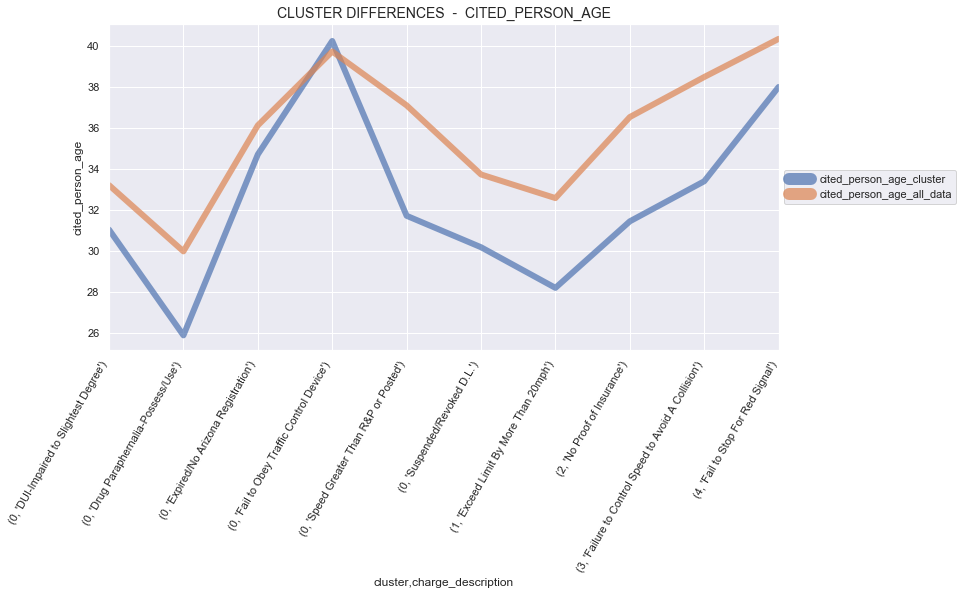

In [78]:
plot_clusters(df, df_clusters, 'cited_person_age')

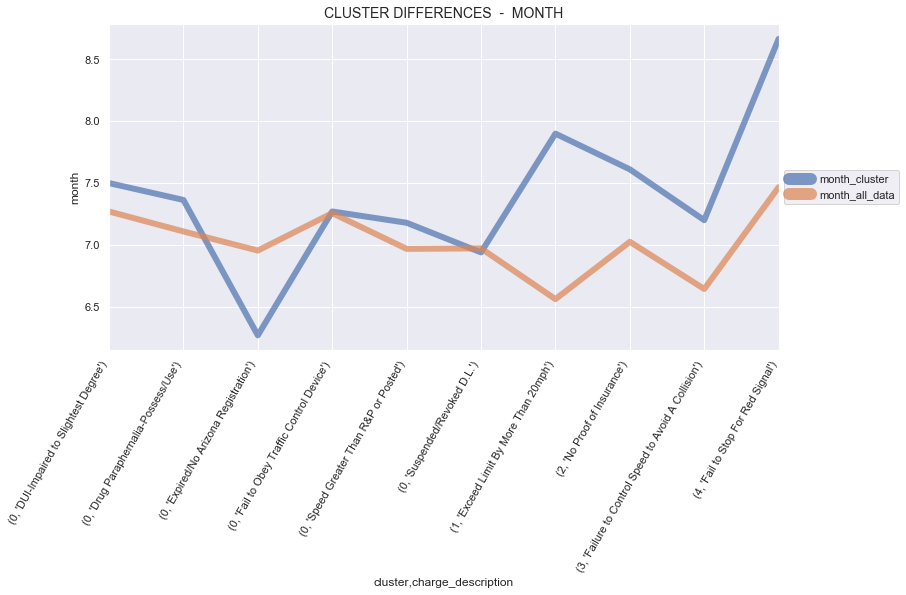

In [79]:
plot_clusters(df, df_clusters, 'month')

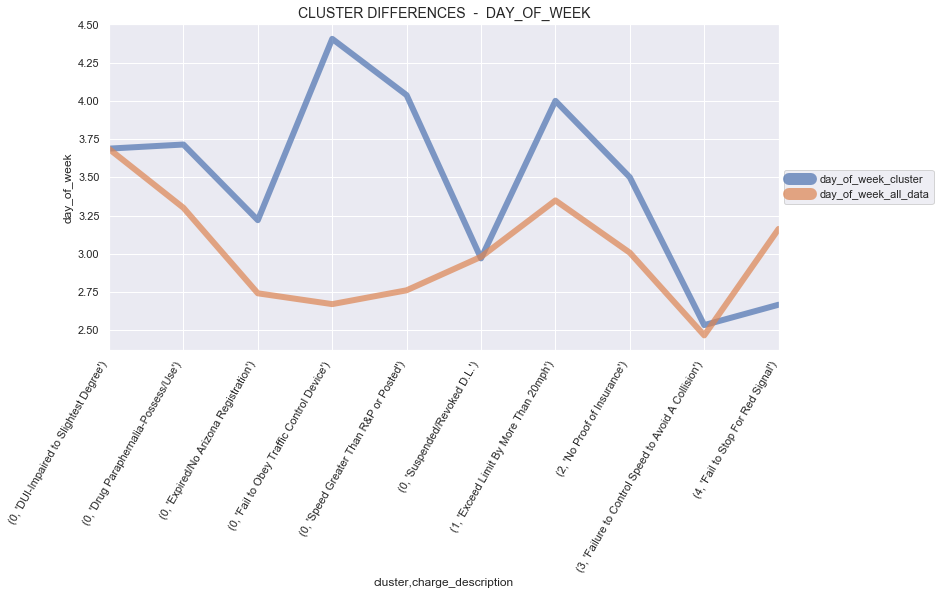

In [80]:
plot_clusters(df, df_clusters, 'day_of_week')

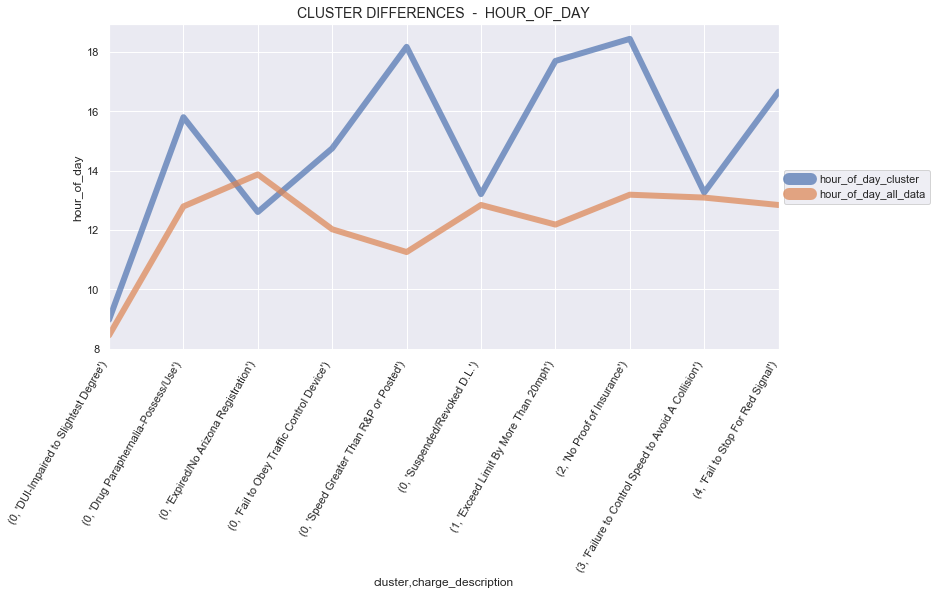

In [81]:
plot_clusters(df, df_clusters, 'hour_of_day')

### N Thompson Peak Py - 1xxx

In [82]:
df_sub = df[df.place_id == 'N Thompson Peak Py - 1xxx']

In [83]:
X = pd.get_dummies(df_sub)

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [84]:
# find best DBSCAN parameters
cluster_count = []
sil_score = []
eps_ = []
min_samples_ = []

for eps in [.1, .5, 1, 5, 10]:
    for min_samples in [5, 10, 25, 50]:
    
        # Defining the agglomerative clustering
        dbscan_cluster = DBSCAN(eps=eps, min_samples=min_samples)

        # Fit model
        clusters = dbscan_cluster.fit_predict(X_std)
        
        # capture cluster count
        cluster_count.append(len(set(clusters)) - (1 if -1 in clusters else 0))
        
        # capture model fit
        if pd.Series(clusters).nunique() > 1:
            sil_score.append(round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3))
        else:
            sil_score.append(np.nan)
        
        # record parameter values
        eps_.append(eps)
        min_samples_.append(min_samples)

In [85]:
# tabulate param results from above
# sort by silhouette score & cluster count
pd.DataFrame(list(list(zip(sil_score, cluster_count, eps_, min_samples_))), 
            columns=['sil_score', 'cluster_count', 'eps', 'min_samples']) \
        .sort_values(by=['sil_score', 'cluster_count'], ascending=False)

sil_score  cluster_count   eps  min_samples
16      0.670              1  10.0            5
17      0.670              1  10.0           10
18      0.670              1  10.0           25
19      0.670              1  10.0           50
12      0.579              4   5.0            5
13      0.578              1   5.0           10
14      0.578              1   5.0           25
15      0.578              1   5.0           50
8       0.343              1   1.0            5
9       0.251              1   1.0           10
10      0.097              1   1.0           25
4      -0.175              7   0.5            5
5      -0.248              2   0.5           10
0         NaN              0   0.1            5
1         NaN              0   0.1           10
2         NaN              0   0.1           25
3         NaN              0   0.1           50
6         NaN              0   0.5           25
7         NaN              0   0.5           50
11        NaN              0   1.0           50

## Model best parameters from above

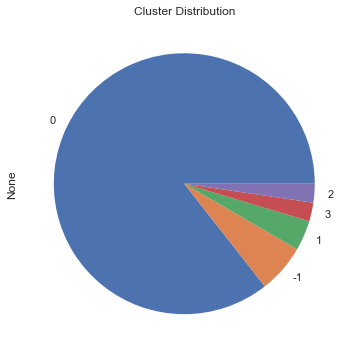

In [86]:
plt.figure(figsize=(6, 6))

dbscan_cluster = DBSCAN(eps=5, min_samples=5)
clusters = dbscan_cluster.fit_predict(X_std)
pd.Series(clusters).value_counts().plot(kind='pie', title='Cluster Distribution');

In [87]:
df_sub.shape

(215, 6)

In [88]:
clusters.shape

(215,)

In [89]:
# format data for plotting
df_clusters = pd.concat([df_sub.reset_index(drop=True), pd.Series(clusters).rename('cluster')], axis=1)

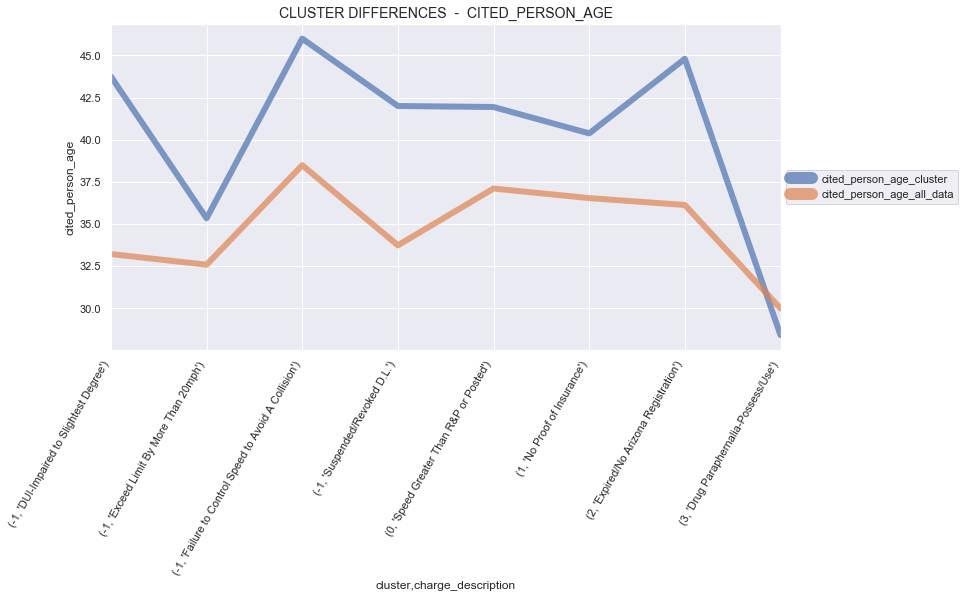

In [90]:
plot_clusters(df, df_clusters, 'cited_person_age')

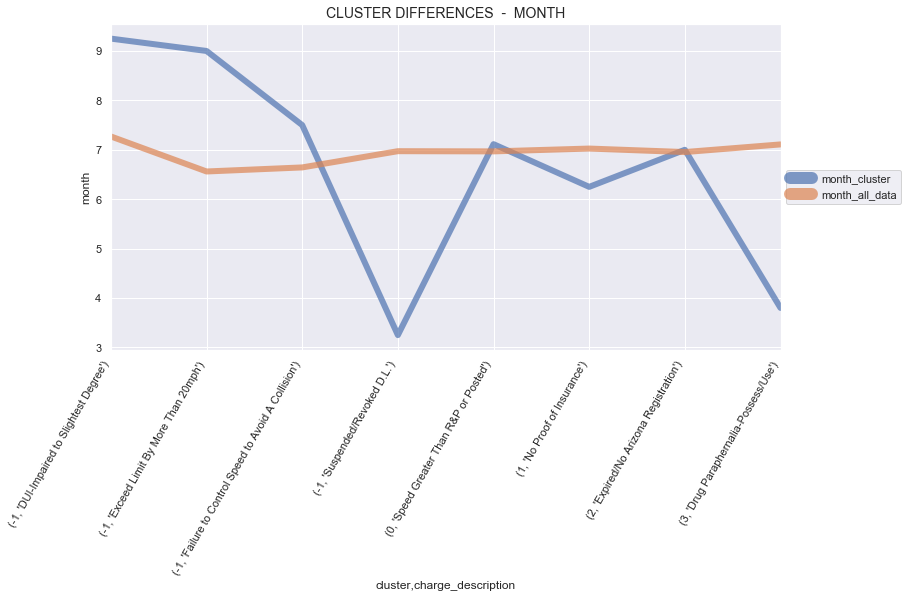

In [91]:
plot_clusters(df, df_clusters, 'month')

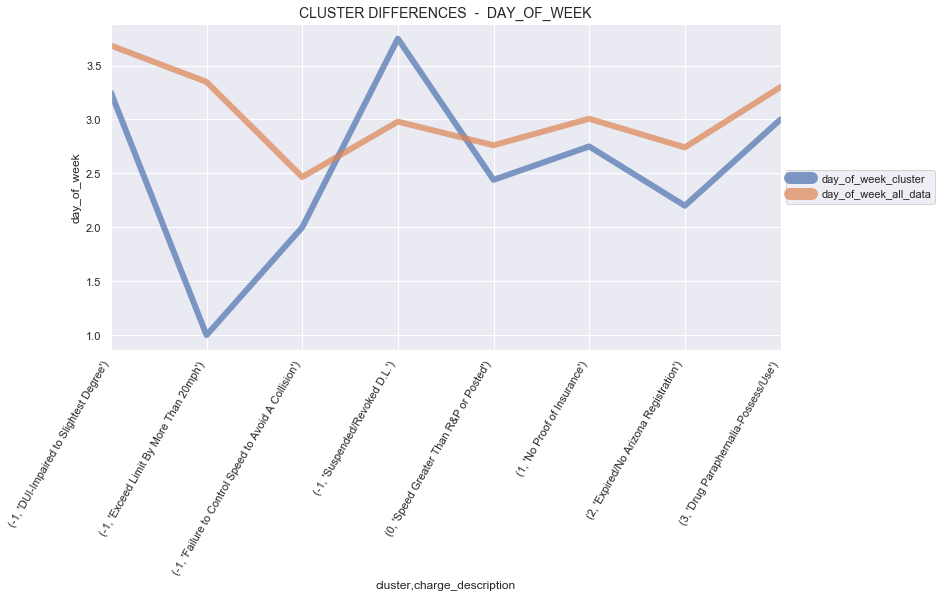

In [92]:
plot_clusters(df, df_clusters, 'day_of_week')

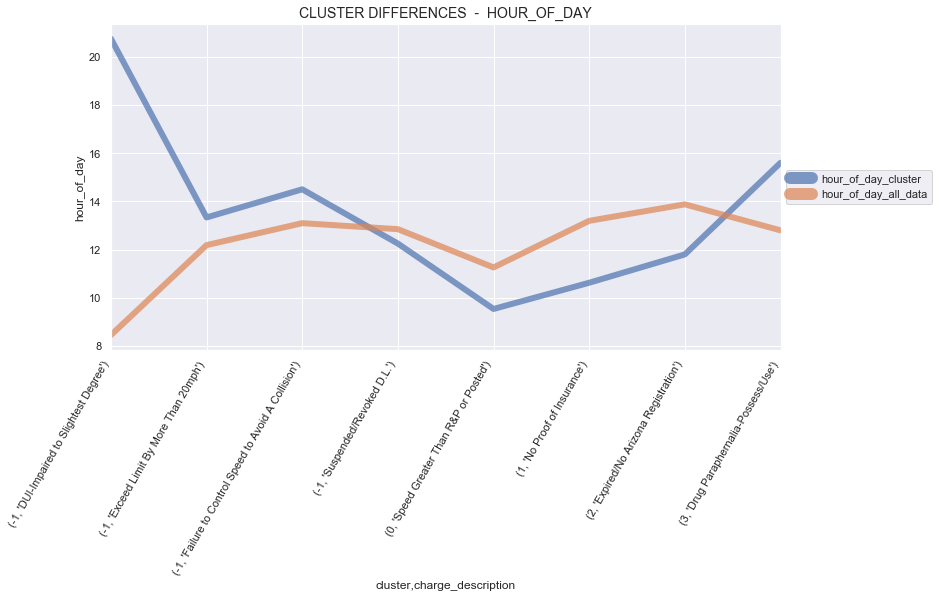

In [93]:
plot_clusters(df, df_clusters, 'hour_of_day')


## CLUSTER USING GMM
<a id='GMM'></a>

In [94]:
X_std.shape

(215, 13)

GMM Parameters to explore
 1. full: This is the default. Each component has its own general covariance matrix.
 1. tied: All components share the same general covariance matrix.
 1. diag: Each component has its own diagonal covariance matrix.
 1. spherical: Each component has its own single variance.

## Examine Clusters Visually

### PCA

In [105]:
# Computing the first principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

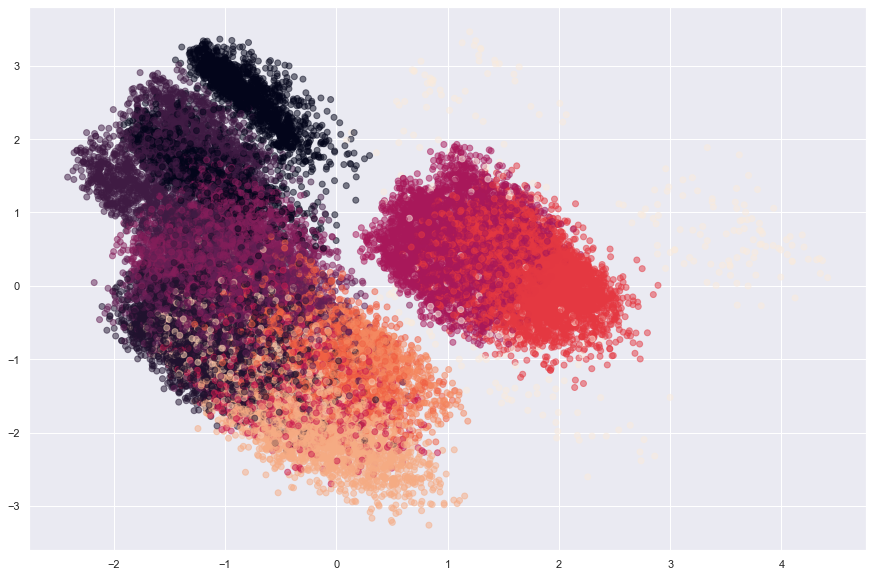

In [106]:
plt.figure(figsize=(15,10))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pd.Series(clusters), alpha=.5);

### t-SNE

In [107]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_std)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 38417 samples in 0.664s...
[t-SNE] Computed neighbors for 38417 samples in 34.447s...
[t-SNE] Computed conditional probabilities for sample 1000 / 38417
[t-SNE] Computed conditional probabilities for sample 2000 / 38417
[t-SNE] Computed conditional probabilities for sample 3000 / 38417
[t-SNE] Computed conditional probabilities for sample 4000 / 38417
[t-SNE] Computed conditional probabilities for sample 5000 / 38417
[t-SNE] Computed conditional probabilities for sample 6000 / 38417
[t-SNE] Computed conditional probabilities for sample 7000 / 38417
[t-SNE] Computed conditional probabilities for sample 8000 / 38417
[t-SNE] Computed conditional probabilities for sample 9000 / 38417
[t-SNE] Computed conditional probabilities for sample 10000 / 38417
[t-SNE] Computed conditional probabilities for sample 11000 / 38417
[t-SNE] Computed conditional probabilities for sample 12000 / 38417
[t-SNE] Computed conditional probabilities for s

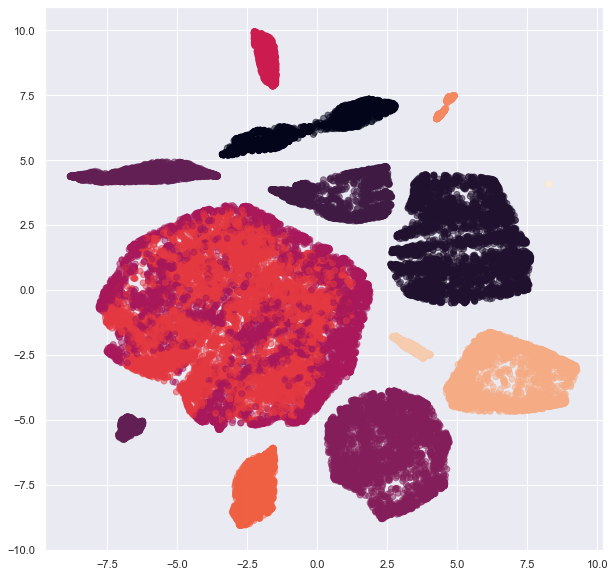

In [108]:
plt.figure(figsize=(10, 10))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=.5, c=pd.Series(clusters));

### UMAP - iteration 1

In [109]:
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_std)

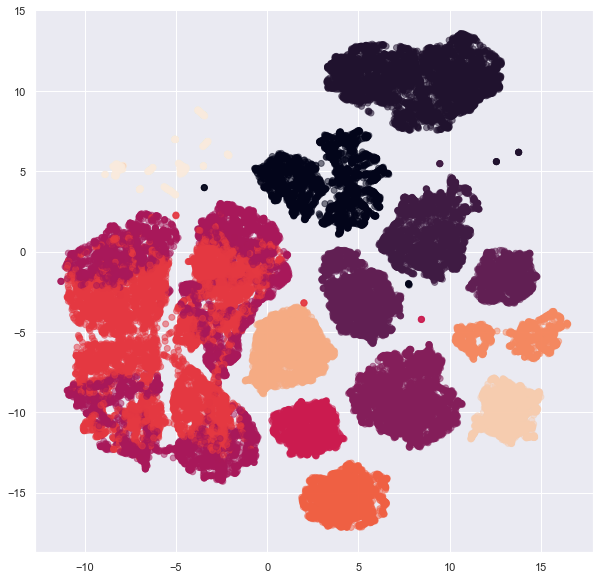

In [110]:
plt.figure(figsize=(10, 10))

plt.scatter(umap_results[:, 0], umap_results[:, 1], alpha=.5, c=pd.Series(clusters));

## HIERARCHICAL CLUSTERING
Since I'm not expecting clusters of equal sizes I will use 'average' linkage method.
<a id='Hierarchical'></a>

In [194]:
# plt.figure(figsize=(6, 6))
# agg_cluster = AgglomerativeClustering(linkage='average', 
#                                       affinity='cosine',
#                                       n_clusters=13)

# clusters = agg_cluster.fit_predict(X_std)
# pd.Series(clusters).value_counts().plot(kind='pie', title='Cluster Distribution');

Running the above produced "MemoryError: unable to allocate array data."  So I sampled 10000 citations below.

In [86]:
# select 10000 random rows
rand_index = np.random.choice(X_std.shape[0], size=10000)

In [87]:
# subset the full dataset
X_std_sample = X_std[rand_index,:]

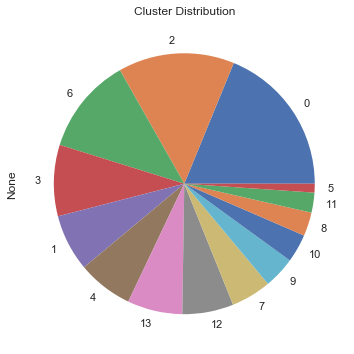

In [88]:
plt.figure(figsize=(6, 6))
agg_cluster = AgglomerativeClustering(linkage='average', 
                                      affinity='cosine',
                                      n_clusters=14)

clusters = agg_cluster.fit_predict(X_std_sample)
pd.Series(clusters).value_counts().plot(kind='pie', title='Cluster Distribution');

In [89]:
pd.Series(clusters).value_counts(dropna=False)

0     1881
2     1440
6     1198
3      883
1      704
4      688
13     682
12     634
7      498
9      392
10     350
8      294
11     247
5      109
dtype: int64

In [91]:
# join cluster assignment to df
df_clusters = pd.concat([df.iloc[pd.Series(rand_index)].reset_index(drop=True),
                         pd.Series(clusters).rename('cluster')], 
                        axis=1)

### EXAMINE CLUSTERS BY LOOKING AT EACH FEATURE


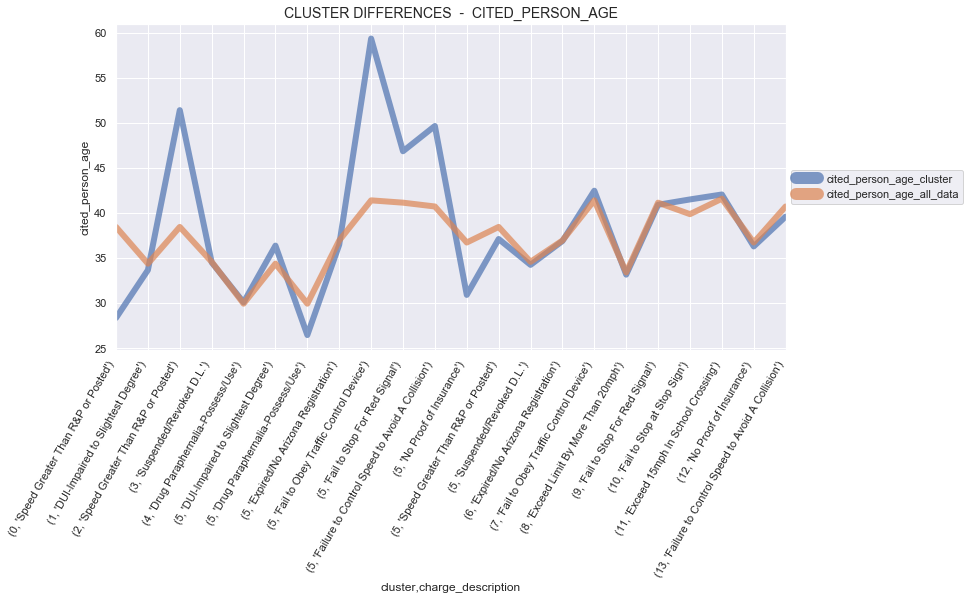

In [109]:
plot_clusters(df, df_clusters, 'cited_person_age')

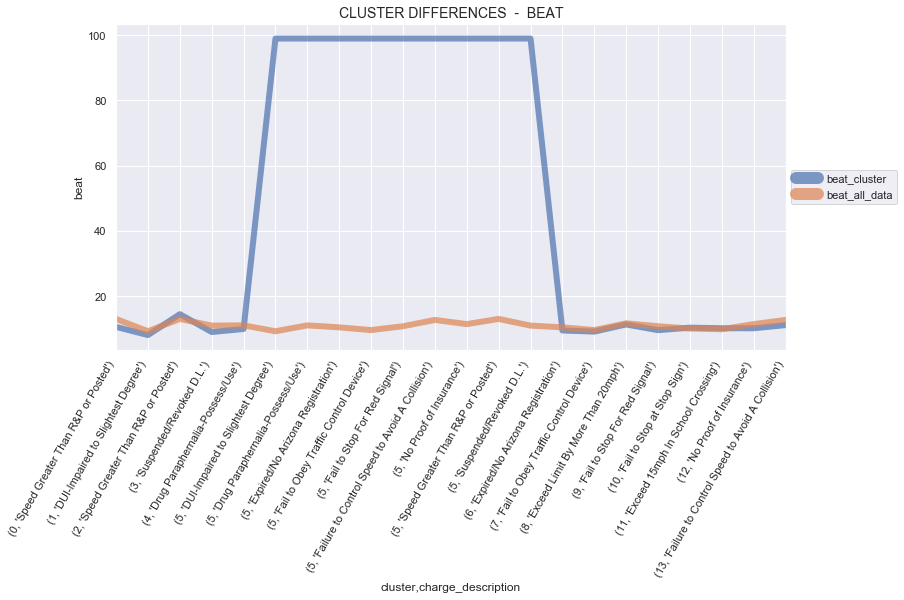

In [110]:
plot_clusters(df, df_clusters, 'beat')

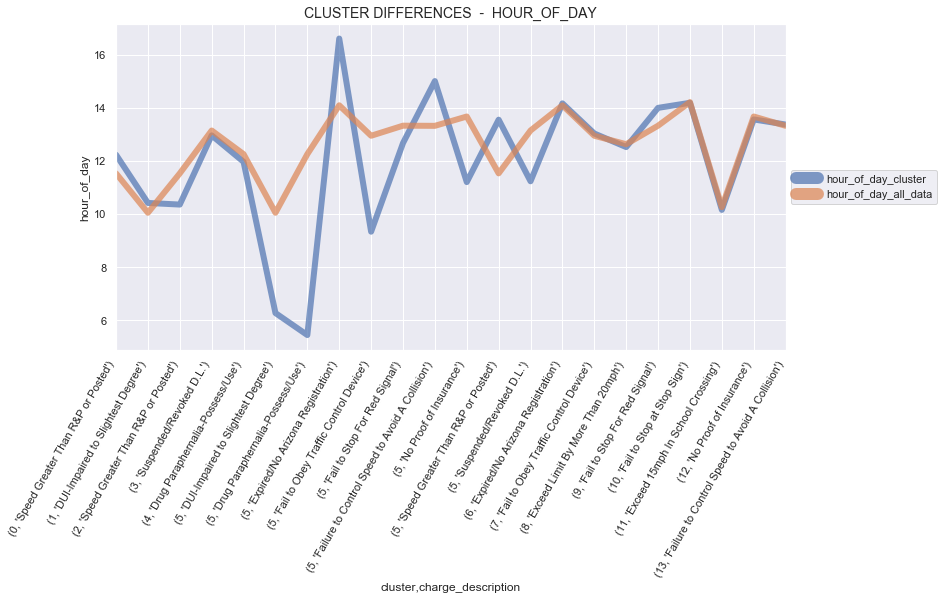

In [111]:
plot_clusters(df, df_clusters, 'hour_of_day')

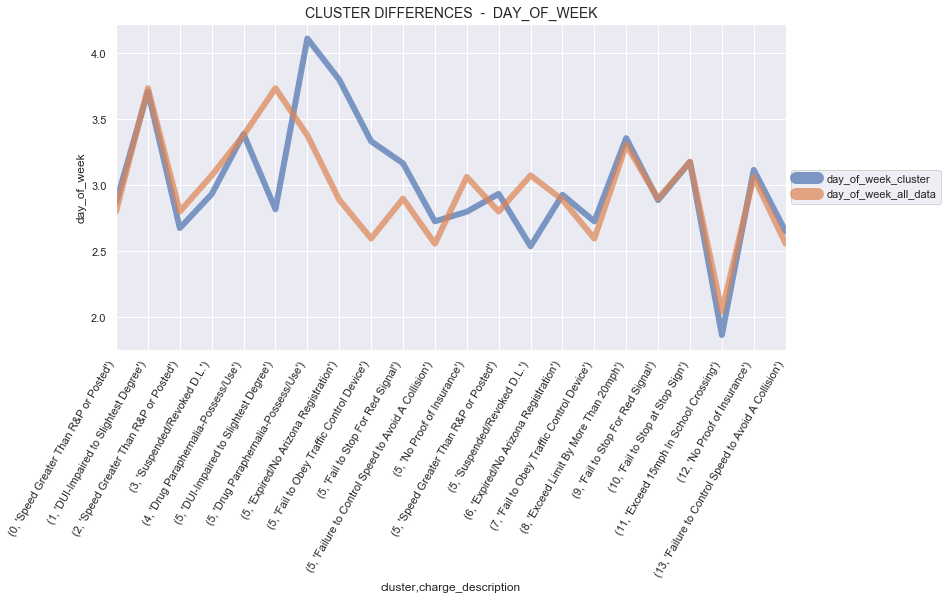

In [112]:
plot_clusters(df, df_clusters, 'day_of_week')

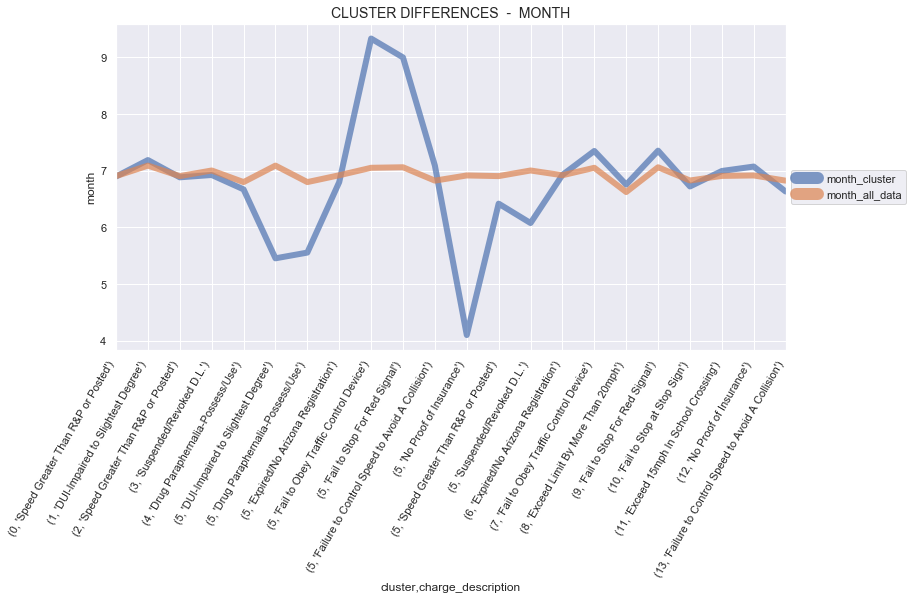

In [113]:
plot_clusters(df, df_clusters, 'month')